# Chapter 07 - Moving Beyond Linearity

In this chapter, we investigate methods where we relax the requirement of linearity. We go through methods in order of non-linearity, or how much the requirement is relaxed. 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm.notebook import tqdm_notebook

import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

colors= [c['color'] for c in plt.rcParams['axes.prop_cycle']]

pd.set_option('display.max_colwidth',None)

## Polynomial Regression

_Polynomial regression_ extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power. For example, a cubic regression uses three variables, $X, X^2$, and $X^3$, as predictors. This approach can be extended up to $d$ degrees, but in practice we rarely go beyond 3 or 4 degrees. 

### Figure 7.1

In [5]:
wage = pd.read_csv('../data/wage.csv')
wage.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

wage = wage.sort_values(by='age')

# Linear regression
y = wage['wage']
age = wage['age']

# Create polynomial features 
poly = PolynomialFeatures(4)
age_poly = poly.fit_transform(age.values.reshape(-1,1))

# Create a test set
age_range = np.arange(18, 80)
age_range_poly = poly.fit_transform(age_range.reshape(-1,1))

**Polynomial Regression with degree = 4**

In [7]:
linreg = LinearRegression()
linreg.fit(age_poly, y)

preds = linreg.predict(age_range_poly)

In [8]:
# Use bootstrapping to get confidence intervals
bootstrap_preds = []
for _ in tqdm_notebook(range(100)):
    boot_idx = np.random.choice(len(age), len(age), replace=True)
    model = LinearRegression()
    model.fit(age_poly[boot_idx], y.iloc[boot_idx])
    
    bootstrap_preds.append(model.predict(age_range_poly))

bootstrap_preds = np.array(bootstrap_preds) 
preds_ci_lower = np.percentile(bootstrap_preds, 2.5, axis=0)
preds_ci_upper = np.percentile(bootstrap_preds, 97.5, axis=0)

**Logistic Regression on `y>250`**

* Sklearn automatically applies regularization, so we set `C=1e10` which is like setting the $\lambda$ parameter to zero. 

In [9]:
y_bin = (wage['wage'] > 250).astype(int)

# Sklearn automat
logreg = sm.Logit(y_bin, age_poly).fit(disp=0)

probs = logreg.predict(age_range_poly)

In [10]:
bootstrap_probs = []
for i in tqdm_notebook(range(1000)):
    boot_idx = np.random.choice(len(age), len(age), replace=True)

    model = sm.Logit(y_bin.iloc[boot_idx], age_poly[boot_idx]).fit(disp=0)
    b_probs = model.predict(age_range_poly)
    
    bootstrap_probs.append(b_probs)

In [11]:
bootstrap_probs = np.array(bootstrap_probs)
probs_ci_lower = np.percentile(bootstrap_probs, 2.5, axis=0)
probs_ci_upper = np.percentile(bootstrap_probs, 97.5, axis=0)

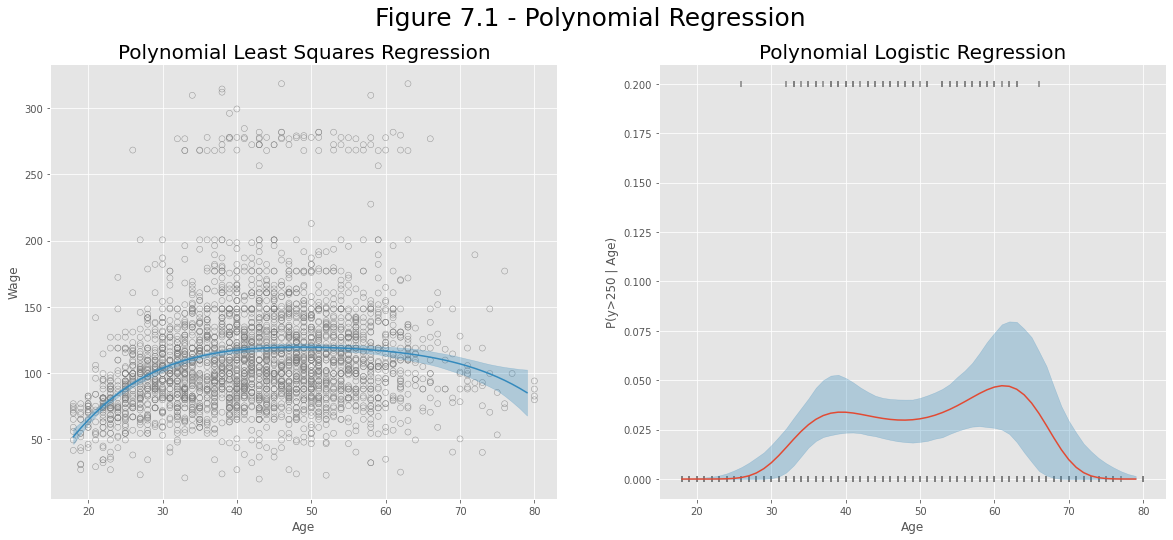

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))

ax=axes[0]
ax.scatter(age, y, facecolor='none', edgecolor='gray', alpha=0.8)
ax.plot(age_range, preds, c=colors[1])
ax.fill_between(age_range, preds_ci_lower, preds_ci_upper, color=colors[1], alpha=.3)
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.set_title('Polynomial Least Squares Regression',fontsize=20);

ax=axes[1]
ax.scatter(age, y_bin/5, marker='|', color='gray')
ax.plot(age_range, probs)
ax.fill_between(age_range, probs_ci_lower, probs_ci_upper, color=colors[1], alpha=.3)

ax.set_xlabel('Age')
ax.set_ylabel('P(y>250 | Age)')
ax.set_title('Polynomial Logistic Regression', fontsize=20)

fig.suptitle('Figure 7.1 - Polynomial Regression', fontsize=25);

## Step Functions

The idea is to break up the range of $X$ into bins, and fit a linear function for each bin. However, this is largely impractical and rarely used in practice, so I will skip this section.

## Basis Functions

A basis function $b$ is any function or transformation that can be applied to a variable $X$. We can then use that transformation, $b_i(X)$ to create a non-linear transformation of $X$ and model that transformation using linear methods such as least-squares regression. Which would be written as:

$$
y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2(x_i) + \ldots + \beta_p b_p(x_i) + \epsilon_i
$$

_Polynomial regression_ and _Step functions_ are thus just special cases of basis functions. 

For Polynomial regression, the basis functions are $b_j(x_i) = x_i^j$. 

## Regression Splines

_Regression splines_ is a flexible class of basis functions that extend upon polynomial regression and step functions. 


### Piecewise Polynomials

Instead of fitting a high-degree polynomial over the entire range of $X$, _piecewise polynomial regression_ involves fitting separate low-degree polynomials over different regions of $X$.

The points where the coefficients change are called _knots_. If we place $K$ different knots throughout the range of $X$, then we will end up fitting $K + 1$ different polynomials.


### Constraints

Without constraints on piecewise linear functions, we will produce overly complex regression lines that are discontinuous at the knots. The goal is ensure smoothness at the knots. 

The general definition of a degree-_d_ spline is that it is a piecewise degree-_d_ polynomial, with continuity in derivatives up to degree $d - 1$ at each knot.


### Spline Basis Representation

How do you ensure continuity up to degree $d - 1$ at each knot? 

It turns out, that by using the _basis function_ representation defined earlier to representing the polynomial and adding a _truncated power basis_ for each knot can ensure just that. 

For more information about the truncated power basis, see the book at page $273$.

### Figure 7.6

In [14]:
wage.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
820,2004,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.243038,69.619037
29,2003,18,1. Male,1. Never Married,2. Black,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.255273,70.476020
2327,2004,18,1. Male,1. Never Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.278754,72.150456
512,2004,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,3.730621,41.704990


In [18]:
# get percentiles
wage['age'].describe()

count    3000.000000
mean       42.414667
std        11.542406
min        18.000000
25%        33.750000
50%        42.000000
75%        51.000000
max        80.000000
Name: age, dtype: float64

In [19]:
from patsy import dmatrix

# Create a design matrix
cubic_x1 = dmatrix(
    "bs(data, knots = (33, 42, 51), include_intercept = False)", 
    {
        "data": wage[['age']]
    }, 
    return_type = 'dataframe'
)

y = wage['wage']

# Then fit a generalised linear model on the cubic splines
model = sm.GLM(y, cubic_x1).fit()

preds = model.predict(cubic_x1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1592.5
Method:                          IRLS   Log-Likelihood:                -15313.
Date:                Tue, 16 Jun 2020   Deviance:                   4.7662e+06
Time:                        09:36:05   Pearson chi2:                 4.77e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   56.1962      7.376      7.619      0.000      41.739      70.653
bs(data, knots=(33, 42, 51), include_intercept=False)[0]    26.7866     12.373      2.165      0.030       2.536      51.037
bs(data, knots=(33, 42, 51), include_intercept=False)[1]    53.4659      7.263      7.361      0.000      39.230      67.702
bs(data, knots=(33, 42, 51), include_intercept=False)[2]    66.1409      8.444      7.833      0.000      49.591      82.690
bs(data, knots=(33, 42, 51), include_intercept=False)[3]    55.8786      8.778      6.366      0.000      38.675      73.082
bs(data, knots=(33, 42, 51), include_intercept=False)[4]    72.3152     13.748      5.260      0.000      45.369      99.261
bs(data, knots=(33, 42, 51), include_intercept=False)[5]    14.8303     16.249      0.913      0.361     -17.018      46.679
============================================================================================================================
"""

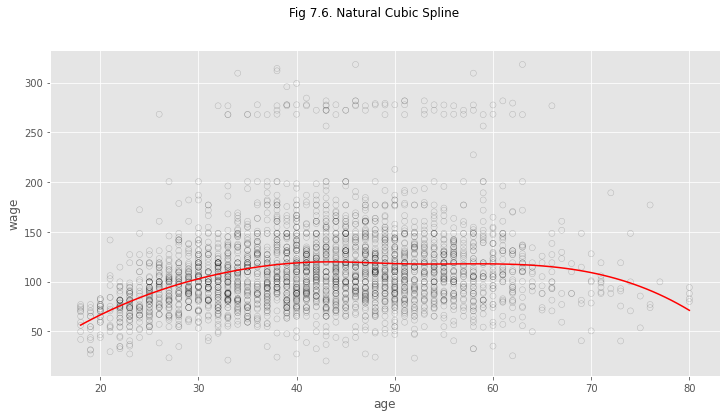

In [26]:
# Create x-axis for making predictions
x_lim = np.linspace(wage[['age']].min(), wage[['age']].max(), 100)
x_lim_dm = dmatrix(
    "bs(data, knots = (33, 42, 51), include_intercept = False)", 
    {
        "data": x_lim
    }, 
    return_type = 'dataframe'
)

x_preds = model.predict(x_lim_dm)

# plot spline
plt.figure(figsize=(12,6))
plt.scatter(wage[['age']], wage['wage'], facecolor='None', edgecolor='k', alpha=0.2)
plt.plot(x_lim, x_preds, color='r', linewidth = 1.5)
plt.suptitle('Fig 7.6. Natural Cubic Spline', fontsize=12)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

### Splines vs Polynomial Regression

Regression splines often produce more stable results than polynomial regression. The reason for this is that polynomials must use a high degree function to produce flexible fits, splines create flexibility by introducing more knots. Furthermore, using splines we can add knots, and thus more flexibility, to certain areas where the function changes more rapidly. 